### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-10/04/20
#### Clasificacion de imagenes motoras en EEG con Fine Tuning
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 47.22%
##### Kappa = 0.2963

##### MobileNetV2
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

##### NASNetLarge
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

##### InceptionResNetV2
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

##### Xception
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical_resize(data):
  dim = (224, 224) #ancho, alto
  fs = 250
  datos = np.zeros((288,224,224,3))
  temporal = np.zeros((528,4,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :, 0] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 1] = Sxx[8:32, :]
      temporal[j*24:(j+1)*24, :, 2] = Sxx[8:32, :]
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a unir_espectrogramas_vertical_resize(data)
x_train = unir_espectrogramas_vertical_resize(x_train)
x_test = unir_espectrogramas_vertical_resize(x_test)

In [12]:
print(x_train.shape)
print(x_test.shape)

(288, 224, 224, 3)
(288, 224, 224, 3)


In [13]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

104.01148692841628
97.16353202276794
0.000332680156177237
0.00024957552372513784
1.1702846570017598
1.1874973133059044


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 105.0
x_test /= 105.0

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9905856
0.92536694
3.1683824e-06
2.3769098e-06
0.011145563
0.01130951


In [16]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

58892288/58889256 [==============================] - 1s 0us/step


In [17]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb07d5981d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb07df8aac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb07df8a630> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb07e50fc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb0fa4a40b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb0fa4a0588> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb0fa49ef28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb0fa49e470> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb0fa49c2b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb0fa49a828> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb07dc2e470> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [0]:
def fine_tuning():
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
9/9 - 1s - loss: 5.2651 - accuracy: 0.4722
kappa:  0.2962962962962963
confusion matrix:
 [[33 18 11 10]
 [27 36  7  2]
 [ 8  8 32 24]
 [ 7  4 26 35]]


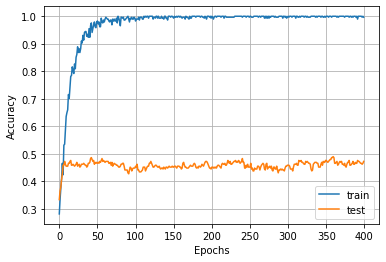

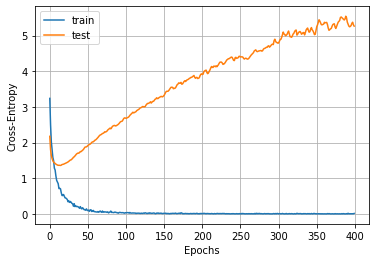

Iteration: 2
9/9 - 1s - loss: 4.7079 - accuracy: 0.4375
kappa:  0.25
confusion matrix:
 [[24 24 12 12]
 [28 36  6  2]
 [12  4 32 24]
 [ 7  4 27 34]]


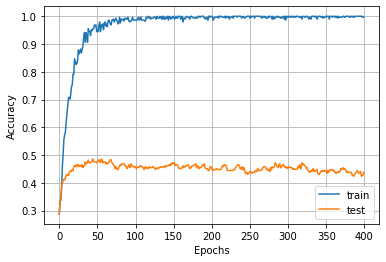

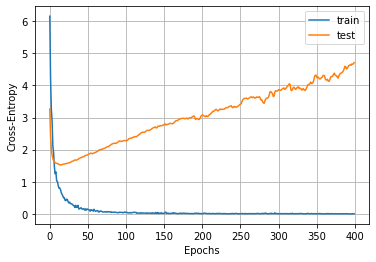


Resultados:
loss: [5.2650837898254395, 4.7078776359558105]
accuracy: [0.4722222089767456, 0.4375]
kappa: [0.2962962962962963, 0.25]


In [27]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = fine_tuning()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [28]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 16,320,644
Trainable params: 8,685,380
Non-trainable params: 7,635,264
_________________________________________________________________


In [29]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4549
std: (+/- 0.0174)
Mean Kappa: 0.2731
std: (+/- 0.0231)
Max Accuracy: 0.4722
Max Kappa: 0.2963
